In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from state_space import simulator,system
from state_space.system import Pendulm
from state_space.simulator import DynamicSystem,TimeVariable,WhiteNoise

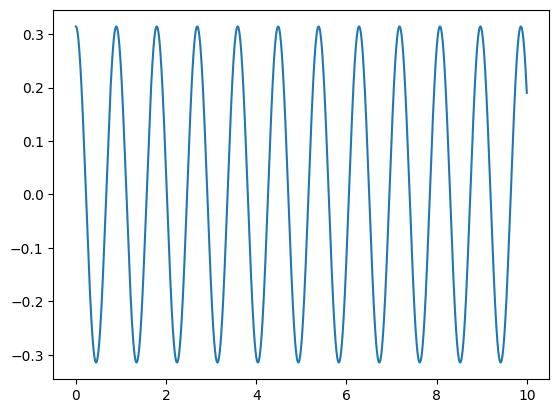

In [2]:
pendulm = Pendulm(1,0.2)
simulator = DynamicSystem(pendulm.A,pendulm.B,pendulm.C,pendulm.D,0.001)
simulator.init(np.array([[np.pi/10],[0]]))
theta = []
for step in range(10000):
    t = simulator.update(0)
    theta.append([simulator.t,t.item()])
    
theta = np.array(theta)
plt.plot(theta[:,0],theta[:,1])

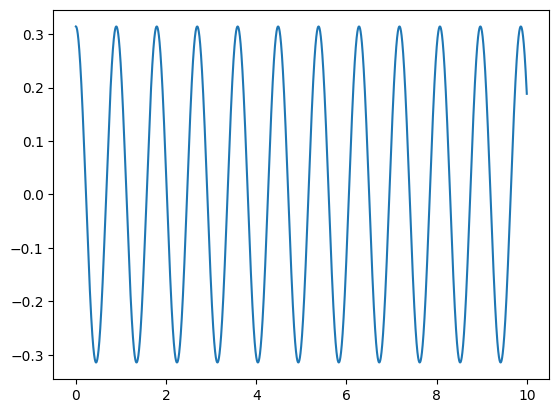

In [3]:
simulator.init(np.array([[np.pi/10],[0]]))
simulator.set_u(0)
simulator.set_t_stop(10)
history = []
for i in simulator:
    history.append([simulator.t,i.item()])
history = np.array(history)
plt.plot(history[:,0],history[:,1])

[0.44225459]


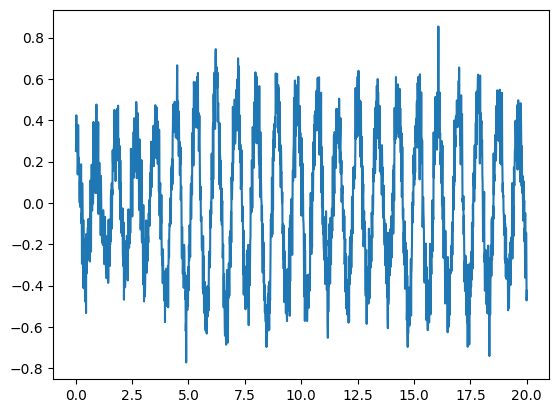

In [4]:
simulator = DynamicSystem(pendulm.A,pendulm.B,pendulm.C,pendulm.D,0.01)
simulator.init(np.array([[np.pi/10],[0]]))
simulator.set_u(0)
simulator.set_t_stop(20)
noise = WhiteNoise(0,0.3)
measure_noise = WhiteNoise(0,0.1)
simulator.u = noise
history = []
for i in simulator:
    history.append([simulator.t,i.item()+measure_noise.u.item()])
history = np.array(history)
plt.plot(history[:,0],history[:,1])
print(simulator.u)

In [5]:

from state_space.kalman_filter import KalmanFilter
from state_space.simulator import DiscreteDynamicSystem
simulator = DynamicSystem(pendulm.A,pendulm.B,pendulm.C,pendulm.D,0.01)
dis_simulator = DiscreteDynamicSystem.from_continous(simulator,np.array([[np.pi/10],[0]]))
filter = KalmanFilter(dis_simulator._A,dis_simulator._B,dis_simulator._C,dis_simulator._x,np.diag((0,1)))

[0.11759022]


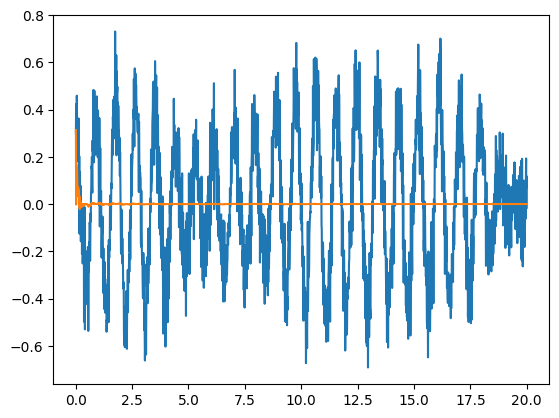

In [6]:
simulator.init(np.array([[np.pi/10],[0]]))
filter.init(simulator.x)
simulator.set_t_stop(20)
noise = WhiteNoise(0,0.3)
measure_noise = WhiteNoise(0,0.1)
simulator.u = noise
history = []
for i in simulator:
    y = i.item()+measure_noise.u.item()
    _,pre = filter.predict(simulator.u)
    filter.update(y)
    history.append([simulator.t,y,pre.item()])
    # history.append([simulator.t,y])
history = np.array(history)
plt.plot(history[:,0],history[:,1])
plt.plot(history[:,0],history[:,2])
print(simulator.u)

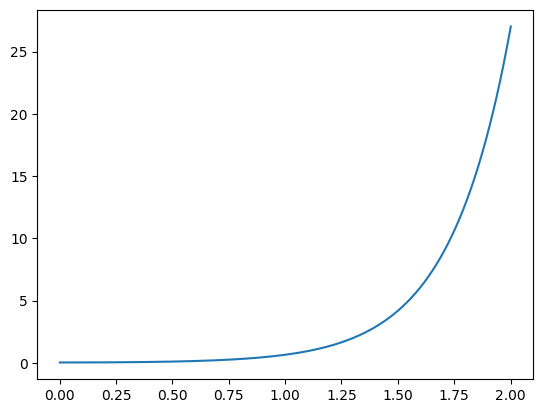

In [7]:
from state_space.system import InvertPendulm
m,M,L = 48,47.7,0.85
simulator = DynamicSystem.from_system(InvertPendulm(m,M,L))
simulator.init(np.array([[0],[0],[np.pi/100],[0]]))
simulator.set_u(0)
simulator.set_t_stop(2)
history = []
for i in simulator:
    history.append([simulator.t,i.item()])
history = np.array(history)
plt.plot(history[:,0],history[:,1])

In [8]:
u = np.array([[1],[2]])
u = np.zeros((3,3))

In [9]:
from state_space.base import Timer
from state_space.transfer_function import Transfer
timer = Timer(1,0.1)
a = Transfer([1],[1,1],0,timer)

In [10]:
for t in a:
    print(t)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
0.9999999999999999
